### [04/24/22] CIFAR10 ResNet20 LR Warmup w/ Rolling Data

In [1]:
from composer.utils.object_store import ObjectStoreProviderHparams
from lth_diet.data import data_diet
from lth_diet.exps import PretrainAndTrainExperiment, TrainExperiment
from lth_diet.utils import utils
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import seaborn as sns
from tqdm import tqdm
plt.style.use("default")
rc = {"figure.figsize": (4, 3), "figure.dpi": 150, "figure.constrained_layout.use": True, "axes.grid": True, 
      "axes.spines.right": False, "axes.spines.top": False, "axes.linewidth": 0.6, "grid.linewidth": 0.6,
      "xtick.major.width": 0.6, "ytick.major.width": 0.6, "xtick.major.size": 4, "ytick.major.size": 4, 
      "axes.labelsize": 11, "axes.titlesize": 11, "xtick.labelsize": 10, "ytick.labelsize": 10,
      "axes.titlepad": 4, "axes.labelpad": 2, "xtick.major.pad": 2, "ytick.major.pad": 2,
      "lines.linewidth": 1.2, 'lines.markeredgecolor': 'w', "patch.linewidth": 0}
sns.set_theme(style='ticks', palette=sns.color_palette("colorblind"), rc=rc)
object_store = ObjectStoreProviderHparams('google_storage', 'prunes', 'GCS_KEY').initialize_object()
bucket_dir = os.environ['OBJECT_STORE_DIR']

In [2]:
def get_accuracy_val(exp, num_reps, object_store, train_prefix=False):
    exp_hash = utils.get_hash(exp.name)
    steps_rt, accs_rt = [], []
    for rep in range(num_reps):
        object_store.download_object(
            f"{bucket_dir}/{exp_hash}/replicate_{rep}/{'train/' if train_prefix else ''}main/log.txt", "temp.txt"
        )
        log = pd.read_table("temp.txt", header=None)[0]
        os.remove("temp.txt")
        steps_t, accs_t = [], []
        for line in log:
            match = re.search('\[EPOCH\]\[step=(\d*)\]: { "accuracy/val": ([+-]?[0-9]*[.]?[0-9]+), \}', line)
            if match:
                steps_t.append(int(match.group(1)))
                accs_t.append(float(match.group(2)))
        steps_rt.append(steps_t)
        accs_rt.append(accs_t)
    steps_rt, accs_rt = np.array(steps_rt), np.array(accs_rt)
    return steps_rt, accs_rt

In [3]:
config = f"../configs/warmup_ablate_cf10_rn20/easy.yaml"
num_replicates = 8
warmups = [100, 200, 400, 600, 800, 1200, 1600, 2400, 3200]
exp = PretrainAndTrainExperiment.create(f=config, cli_args=False)
exp.pretrain_data.dataset_transforms[0].class_balanced = True
accs_all_warm = []
for warmup in warmups:
    exp.pretrain_duration = f"{warmup}ba"
    _, accs_rt = get_accuracy_val(exp, num_replicates, object_store, train_prefix=True)
    accs_all_warm.append(accs_rt[:, -1])
accs_all_warm = np.array(accs_all_warm)

In [47]:
config = f"../configs/warmup_ablate_cf10_rn20/easy.yaml"
num_replicates = 8
offsets = [0, 25000, 37500, 39760]
warmups = [100, 200, 400, 600, 800, 1200, 1600, 2400, 3200]
exp = PretrainAndTrainExperiment.create(f=config, cli_args=False)
exp.pretrain_data.dataset_transforms[0].score = "error_norm_cifar10_resnet20_warmup1600ba_16reps_seed6714"
exp.pretrain_data.dataset_transforms[0].size = 10240
accs_off_warm = []
for offset in tqdm(offsets):
    accs_warm = []
    for warmup in warmups:
        exp.pretrain_data.dataset_transforms[0].left_offset = offset
        exp.pretrain_duration = f"{warmup}ba"
        _, accs_rt = get_accuracy_val(exp, num_replicates, object_store, train_prefix=True)
        accs_warm.append(accs_rt[:, -1])
    accs_off_warm.append(accs_warm)
accs_off_warm = np.array(accs_off_warm)

100%|██████████| 4/4 [02:15<00:00, 33.98s/it]


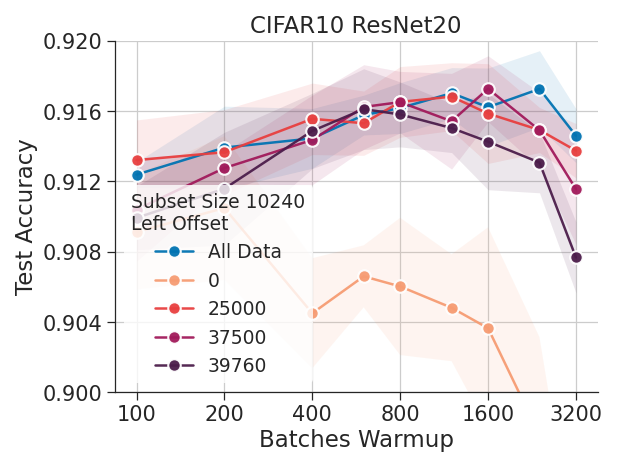

In [62]:
fig, axes = plt.subplots(dpi=150)
ls = []
ax = axes
x, ys, c = np.array(warmups), accs_all_warm, "C0"
ym, ye = ys.mean(-1), ys.std(-1)
l = ax.plot(np.log2(x/100), ym, marker="o", alpha=0.95, c="C0", label="All Data")
ax.fill_between(np.log2(x/100), ym-ye, ym+ye, alpha=0.1, color="C0")
x, ys, cs = np.array(warmups), accs_off_warm, sns.color_palette("rocket_r", n_colors=len(offsets))
ym, ye = ys.mean(-1), ys.std(-1)
for off in range(len(offsets)):
    l = ax.plot(np.log2(x/100), ym[off], marker="o", alpha=0.95, c=cs[off], label=f"{offsets[off]}")
    ax.fill_between(np.log2(x/100), ym[off]-ye[off], ym[off]+ye[off], alpha=0.1, color=cs[off])
ax.legend(fontsize=9, title="Subset Size 10240\nLeft Offset", title_fontsize=9, loc=3)
ax.set_ylim(0.9, 0.92)
ax.set_yticks(np.linspace(0.9, 0.92, 6))
ax.set_xticks([0, 1, 2, 3, 4, 5], [100, 200, 400, 800, 1600, 3200])
ax.set_xlabel("Batches Warmup")
ax.set_ylabel("Test Accuracy")
ax.set_title("CIFAR10 ResNet20")
fig.show()

In [63]:
config = f"../configs/warmup_ablate_cf10_rn20/random.yaml"
num_replicates = 8
sizes = [10240, 50000]
warmups = [100, 200, 400, 600, 800, 1200, 1600, 2400, 3200]
exp = PretrainAndTrainExperiment.create(f=config, cli_args=False)
accs_size_warm = []
for size in tqdm(sizes):
    accs_warm = []
    for warmup in warmups:
        exp.pretrain_duration = f"{warmup}ba"
        exp.pretrain_data.dataset_transforms[0].size = size
        _, accs_rt = get_accuracy_val(exp, num_replicates, object_store, train_prefix=True)
        accs_warm.append(accs_rt[:, -1])
    accs_size_warm.append(accs_warm)
accs_size_warm = np.array(accs_size_warm)

100%|██████████| 2/2 [01:13<00:00, 36.89s/it]


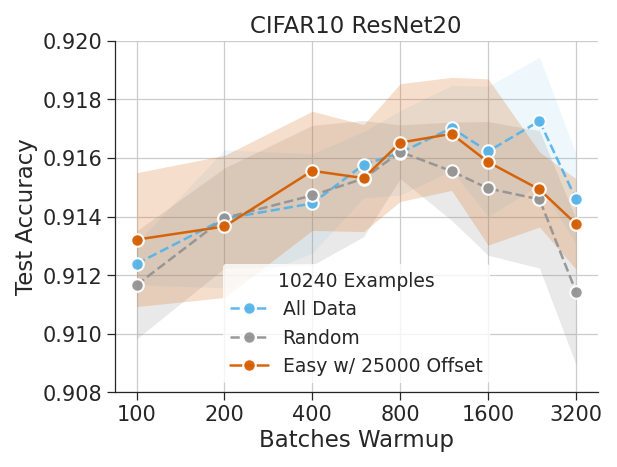

In [94]:
fig, axes = plt.subplots(dpi=150)
ls = []
ax = axes
x, ys, c = np.array(warmups), accs_size_warm[-1], "C9"
ym, ye = ys.mean(-1), ys.std(-1)
l = ax.plot(np.log2(x/100), ym, marker="o", alpha=0.95, c=c, ls="--", label="All Data")
ax.fill_between(np.log2(x/100), ym-ye, ym+ye, alpha=0.1, color=c)
x, ys, c = np.array(warmups), accs_size_warm[0], "C7"
ym, ye = ys.mean(-1), ys.std(-1)
l = ax.plot(np.log2(x/100), ym, marker="o", alpha=0.95, c=c, ls="--", label="Random")
ax.fill_between(np.log2(x/100), ym-ye, ym+ye, alpha=0.2, color=c)
x, ys, c = np.array(warmups), accs_off_warm[1], "C3"
ym, ye = ys.mean(-1), ys.std(-1)
l = ax.plot(np.log2(x/100), ym, marker="o", alpha=0.95, c=c, label="Easy w/ 25000 Offset")
ax.fill_between(np.log2(x/100), ym-ye, ym+ye, alpha=0.2, color=c)
ax.legend(fontsize=9, loc=8, title="10240 Examples", title_fontsize=9)
ax.set_ylim(0.908, 0.92)
ax.set_yticks(np.linspace(0.908, 0.92, 7))
ax.set_xticks([0, 1, 2, 3, 4, 5], [100, 200, 400, 800, 1600, 3200])
ax.set_xlabel("Batches Warmup")
ax.set_ylabel("Test Accuracy")
ax.set_title("CIFAR10 ResNet20")
fig.show()